In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import re
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('../../Data/bird_dataset.csv', index_col=0)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Dropping columns with null values
bird_df = df.drop(columns=['SpecID', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo', 
                      'Scientific', 'English', 'Diet-Source', 'Diet-EnteredBy', 'ForStrat-Source',
                       'ForStrat-EnteredBy', 'BodyMass-Comment', 'BodyMass-Source', 'Record-Comment', 'Unnamed: 0.1', 
                      'English name', 'Family'])

In [4]:
dd_df = bird_df[bird_df['Global IUCN Red List Category'] == 'DD']

In [5]:
dd_df = dd_df.drop(columns=['Global IUCN Red List Category'])

In [6]:
# Dropping DD from bird_df
bird_df = bird_df.drop(index=dd_df.index)

In [7]:
# Creating target column
bird_df['threatened'] = [0.0 if x in ['NT', 'LC'] else 1.0 for x in bird_df['Global IUCN Red List Category']]

In [8]:
X = bird_df.drop(columns=['Global IUCN Red List Category', 'threatened'])
y = bird_df['threatened']

In [9]:
# Creating 10% holdout sets for testing the final model
X_t, X_hold, y_t, y_hold = train_test_split(X,y,random_state=42,stratify=y,test_size=0.1)

In [10]:
# Creating data for training (75% of original)/testing(15% of original)
X_train, X_test, y_train, y_test = train_test_split(X_t,y_t,random_state=42,stratify=y_t,test_size=15/90)

In [11]:
# Setting up some pipelines
# Numeric columns 
num_col = ['BodyMass-Value']
num_pipe = Pipeline([('min_max', MinMaxScaler())])

In [12]:
# Proportional numeric columns
diets = [c for c in X_train.columns if re.search('Diet.+',c)]
strats = [c for c in X_train.columns if re.search('ForStrat.+',c)]

diets = diets[:10]
strats = strats[:7]

prop_cols = strats+diets

prop_pipe = Pipeline([('div100', FunctionTransformer(lambda x: x/100))])

In [13]:
# Categorical columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype=='object']

cat_pipe = Pipeline([('ohe', OneHotEncoder())])

In [14]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipe, num_col),
    ('proportional', prop_pipe, prop_cols),
    ('categorical', cat_pipe, cat_cols)
],
                                remainder='passthrough')

# Decision Tree Modeling

In [15]:
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('dt', DecisionTreeClassifier())])

dt_grid = {'dt__max_depth': [3,5,50],
          'dt__min_samples_split': [2,5,10],
          'dt__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

dt_gs = GridSearchCV(estimator=dt_pipe, param_grid=dt_grid, scoring=scoring_metrics, refit='recall')

In [16]:
dt_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7f9d1238caf0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [17]:
pd.DataFrame(dt_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.033451,0.002910,0.010709,0.001162,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.027469,0.001517,0.008786,0.000489,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.025974,0.000926,0.008416,0.000696,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
3,0.033680,0.001427,0.009261,0.001068,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.664894,0.659574,...,0.022960,6,0.636132,0.626263,0.604167,0.629032,0.670185,0.633156,0.021377,9
4,0.037552,0.003428,0.010555,0.001449,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.686170,0.659574,...,0.028152,5,0.649874,0.626263,0.604167,0.625337,0.670185,0.635165,0.022713,8
5,0.044668,0.003912,0.012078,0.002470,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.680851,0.654255,...,0.024309,4,0.648101,0.624365,0.607792,0.629032,0.670185,0.635895,0.021422,7
6,0.054004,0.005712,0.010683,0.001435,gini,50,2,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.574468,0.569149,...,0.038272,13,0.568421,0.563158,0.600000,0.620513,0.558659,0.582150,0.024047,14
7,0.044910,0.003692,0.009955,0.001691,gini,50,5,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.547872,0.537234,...,0.032535,15,0.546419,0.545946,0.600536,0.608466,0.564246,0.573123,0.026575,16
8,0.051935,0.003689,0.011214,0.001661,gini,50,10,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.558511,0.547872,...,0.021066,18,0.560000,0.553763,0.583569,0.592000,0.573913,0.572649,0.014227,17
9,0.031447,0.001728,0.009343,0.000628,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,10


AUC Score: 0.802147614167049


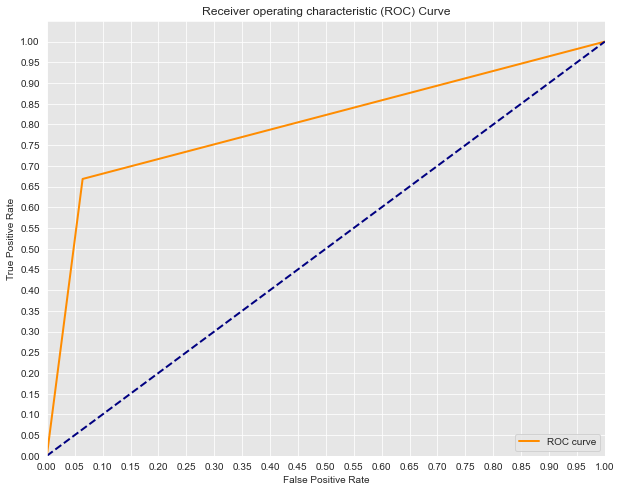

In [18]:
y_score = dt_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [19]:
# Okay scores
print("Train score:",dt_gs.score(X_train,y_train))
print("Test score: ",dt_gs.score(X_test,y_test))

Train score: 0.687299893276414
Test score:  0.6684491978609626


# Logistic Regression Modeling

In [20]:
log_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('log', LogisticRegression())])

log_grid = {'log__class_weight': [None,'balanced'],
          'log__penalty': ['l1', 'l2'],
          'log__C': [.1,.25,.5,1.0],
           'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs = GridSearchCV(estimator=log_pipe, param_grid=log_grid, scoring=scoring_metrics, refit='recall')

In [21]:
log1 = log_gs.fit(X_train,y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

In [22]:
pd.DataFrame(log1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.015901,0.001495,0.000000,0.000000,0.1,None,100,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
1,0.048779,0.002523,0.009855,0.001646,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.018048,0.001925,0.000000,0.000000,0.1,None,1000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
3,0.054283,0.011074,0.011959,0.002717,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
4,0.014807,0.000604,0.000000,0.000000,0.1,None,10000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
5,0.051265,0.004275,0.008526,0.000759,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
6,0.014118,0.001475,0.000000,0.000000,0.1,balanced,100,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
7,0.060755,0.008120,0.008849,0.000383,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
8,0.017089,0.002020,0.000000,0.000000,0.1,balanced,1000,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
9,0.062801,0.003389,0.010417,0.000875,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10


In [23]:
log1.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.9016205738692649


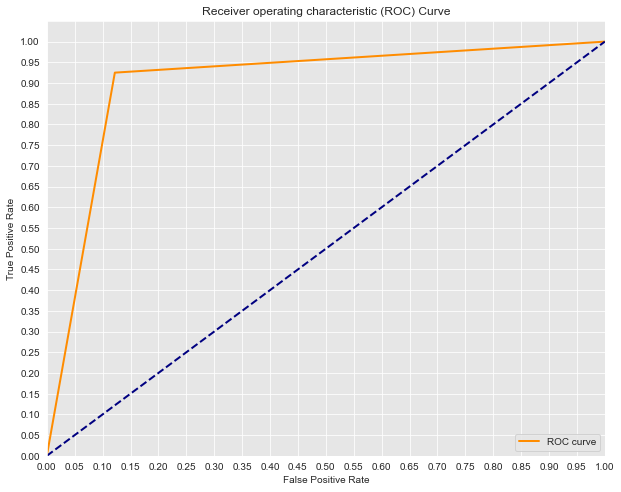

In [24]:
y_score = log1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [25]:
# Good baseline score
print("Train score:",log1.score(X_train,y_train))
print("Test score: ",log1.score(X_test,y_test))

Train score: 0.9327641408751334
Test score:  0.9251336898395722


In [26]:
log_pipe_2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('log', LogisticRegression())])

log_grid_2 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_2 = GridSearchCV(estimator=log_pipe_2, param_grid=log_grid_2, scoring=scoring_metrics, refit='recall')

In [27]:
log2 = log_gs_2.fit(X_train,y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [28]:
pd.DataFrame(log2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.048061,0.003771,0.009615,0.000989,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
1,0.046746,0.002950,0.010004,0.002599,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.064277,0.003025,0.013054,0.001780,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
3,0.072857,0.006162,0.013399,0.001895,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
4,0.079921,0.008593,0.012928,0.001407,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
5,0.079124,0.009594,0.013086,0.001410,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
6,0.081737,0.006012,0.012046,0.000594,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
7,0.084027,0.009880,0.013662,0.001107,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
8,0.082888,0.008051,0.011986,0.001734,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
9,0.076194,0.002686,0.011423,0.001170,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4


In [29]:
log2.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.9016205738692649


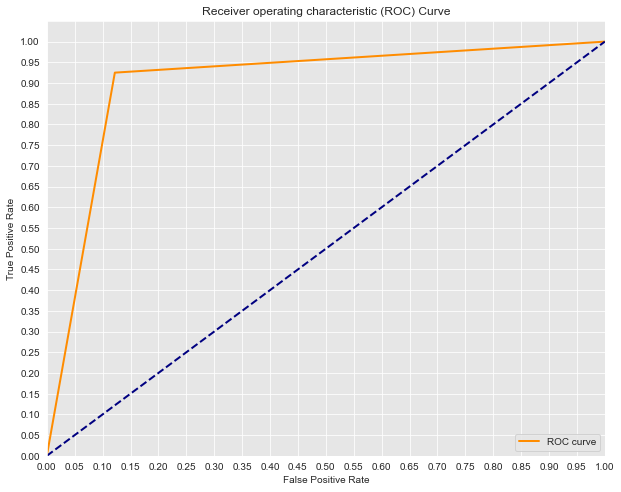

In [30]:
y_score = log2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [31]:
# Same as above
print("Train score:",log2.score(X_train,y_train))
print("Test score: ",log2.score(X_test,y_test))

Train score: 0.9327641408751334
Test score:  0.9251336898395722


In [32]:
data_train = [X_train['agriculture_threat'], X_train['biological_threat'], X_train['climate_change_threat'],
              X_train['energy_mining_threat'], X_train['geological_threat'], X_train['human_intrusions_threat'],
              X_train['natural_systems_threat'], X_train['pollution_threat'], X_train['res_comm_dev_threat'], 
              X_train['transportation_threat'], X_train['invasive_threat']]

threats_train = pd.concat(data_train, axis=1)

In [33]:
data_test = [X_test['agriculture_threat'], X_test['biological_threat'], X_test['climate_change_threat'],
              X_test['energy_mining_threat'], X_test['geological_threat'], X_test['human_intrusions_threat'],
              X_test['natural_systems_threat'], X_test['pollution_threat'], X_test['res_comm_dev_threat'], 
              X_test['transportation_threat'], X_test['invasive_threat']]

threats_test = pd.concat(data_test, axis=1)

In [34]:
log_pipe_3 = Pipeline(steps=[('log', LogisticRegression())])

log_grid_3 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l1', 'l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_3 = GridSearchCV(estimator=log_pipe_3, param_grid=log_grid_3, scoring=scoring_metrics, refit='recall')

In [35]:
log3 = log_gs_3.fit(threats_train,y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

In [36]:
pd.DataFrame(log3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.001432,0.000239,0.000000,0.000000,0.1,None,100,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
1,0.015982,0.001399,0.005561,0.000702,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.000903,0.000100,0.000000,0.000000,0.1,None,1000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
3,0.018783,0.002730,0.005979,0.001530,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
4,0.001100,0.000370,0.000000,0.000000,0.1,None,10000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41
5,0.016806,0.002951,0.005220,0.000695,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
6,0.000838,0.000134,0.000000,0.000000,0.1,balanced,100,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
7,0.017597,0.003673,0.005560,0.000383,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
8,0.000926,0.000245,0.000000,0.000000,0.1,balanced,1000,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35
9,0.016571,0.002401,0.005316,0.000828,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1


In [37]:
log3.best_params_

{'log__C': 1.0,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.8663273138955954


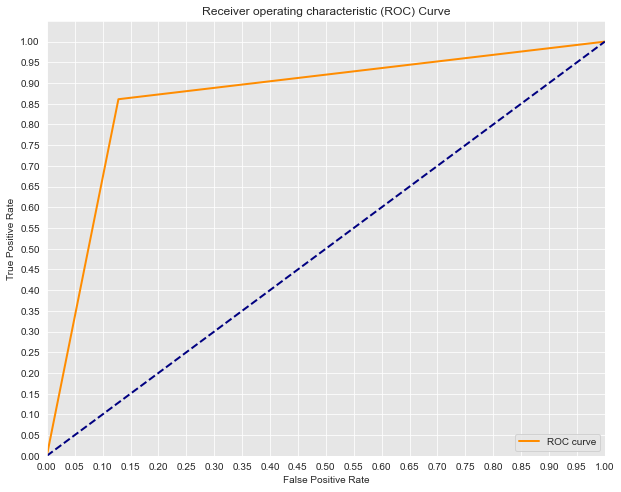

In [38]:
y_score = log3.predict(threats_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [39]:
# Not as good as above, but still pretty good. Slightly overfit.
print("Train score:",log3.score(threats_train,y_train))
print("Test score: ",log3.score(threats_test,y_test))

Train score: 0.9092849519743863
Test score:  0.8609625668449198


In [40]:
log_pipe_4 = Pipeline(steps=[('log', LogisticRegression())])

log_grid_4 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_4 = GridSearchCV(estimator=log_pipe_4, param_grid=log_grid_4, scoring=scoring_metrics, refit='recall')

In [41]:
log4 = log_gs_4.fit(threats_train,y_train)

In [42]:
pd.DataFrame(log4.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.014977,0.001489,0.005181,0.000422,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
1,0.015288,0.000637,0.005436,0.000846,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.016141,0.001219,0.005476,0.000969,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
3,0.017410,0.003362,0.005095,0.000629,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.016688,0.001744,0.005512,0.000874,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.017677,0.002202,0.004760,0.000624,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
6,0.014735,0.001797,0.004947,0.000716,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
7,0.012719,0.000507,0.004051,0.000180,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
8,0.014264,0.001856,0.004769,0.001205,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
9,0.017393,0.001792,0.004973,0.000598,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7


In [43]:
# This configuration seems to keep coming up as the best performing set of parameters
log4.best_params_

{'log__C': 1.0,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.8663273138955954


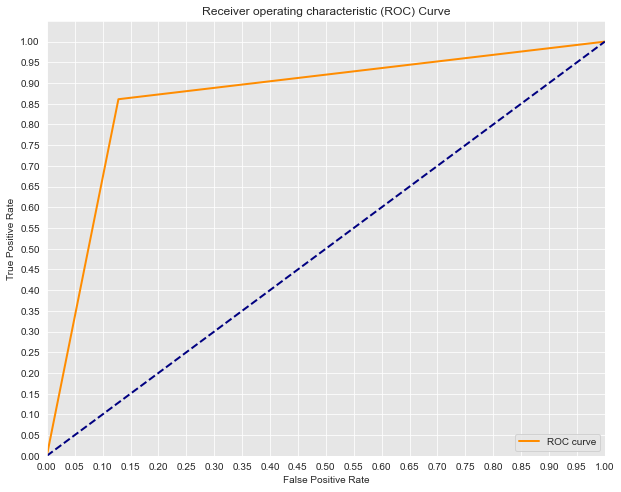

In [44]:
y_score = log4.predict(threats_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [45]:
# Not as good as above, but still pretty good. Slightly overfit.
print("Train score:",log4.score(threats_train,y_train))
print("Test score: ",log4.score(threats_test,y_test))

Train score: 0.9092849519743863
Test score:  0.8609625668449198


# Random Forest Modeling

In [46]:
for_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('for', RandomForestClassifier())])

for_grid1 = {'for__n_estimators': [10,100,1000],
          'for__max_depth': [2,5,10],
          'for__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

for_gs1 = GridSearchCV(estimator=for_pipe1, param_grid=for_grid1, scoring=scoring_metrics, refit='recall')

In [47]:
for1 = for_gs1.fit(X_train,y_train)

In [48]:
pd.DataFrame(for1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__n_estimators,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.049814,0.005937,0.013282,0.000929,gini,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.010638,0.015957,...,0.006227,14,0.021053,0.031250,0.041237,0.010638,0.010638,0.022963,0.011917,14
1,0.255322,0.015905,0.025931,0.002190,gini,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,0.000000,...,0.002615,15,0.010582,0.000000,0.000000,0.010582,0.010638,0.006360,0.005193,15
2,2.979531,0.818910,0.231191,0.080097,gini,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,0.005319,...,0.002613,17,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,17
3,0.106954,0.022942,0.028531,0.007917,gini,5,10,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.287234,0.356383,...,0.041176,12,0.420233,0.476868,0.357143,0.426966,0.468864,0.430015,0.042708,12
4,0.831054,0.025132,0.072700,0.007526,gini,5,100,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.345745,0.308511,...,0.021525,9,0.477941,0.444444,0.437736,0.430657,0.406250,0.439406,0.023191,11
5,4.491294,2.141349,0.197745,0.073742,gini,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.340426,0.329787,...,0.018185,8,0.481203,0.464419,0.440299,0.418605,0.440154,0.448936,0.021692,8
6,0.055407,0.000986,0.010730,0.000280,gini,10,10,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.553191,0.531915,...,0.022580,5,0.597701,0.595238,0.633721,0.641399,0.599407,0.613493,0.019844,5
7,0.407457,0.009607,0.028721,0.004028,gini,10,100,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.553191,0.569149,...,0.019639,3,0.617211,0.620290,0.651026,0.641399,0.666667,0.639319,0.018656,3
8,3.928669,0.038452,0.186561,0.007008,gini,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.595745,0.590426,...,0.021321,2,0.654971,0.637931,0.654971,0.609467,0.666667,0.644801,0.019903,2
9,0.036310,0.000958,0.010362,0.000766,entropy,2,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.015957,0.000000,...,0.019847,13,0.031414,0.000000,0.108374,0.072165,0.052083,0.052807,0.036631,13


In [49]:
for1.best_params_

{'for__criterion': 'entropy', 'for__max_depth': 10, 'for__n_estimators': 1000}

AUC Score: 0.767383967511332


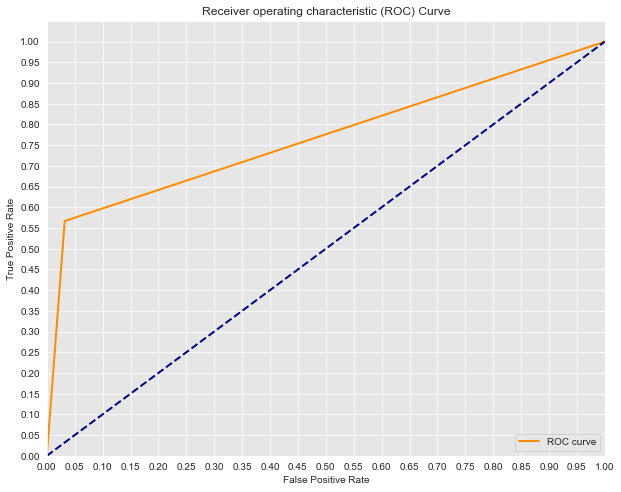

In [50]:
y_score = for1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [51]:
# Overfitting
print("Train score:",for1.score(X_train,y_train))
print("Test score: ",for1.score(X_test,y_test))

Train score: 0.8313767342582711
Test score:  0.5668449197860963


In [52]:
for_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('for', RandomForestClassifier())])

for_grid2 = {'for__n_estimators': [10,100,1000],
             'for__max_depth': [2,5,10,50,100],
             'for__min_samples_split': [2,5,10],
             'for__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

for_gs2 = GridSearchCV(estimator=for_pipe2, param_grid=for_grid2, scoring=scoring_metrics, refit='recall')

In [53]:
for2 = for_gs2.fit(X_train,y_train)

In [54]:
pd.DataFrame(for2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__min_samples_split,param_for__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.036784,0.001363,0.010102,0.000566,gini,2,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.010638,...,0.023338,77,0.021053,0.000000,0.021053,0.010417,0.117647,0.034034,0.042531,77
1,0.224698,0.007432,0.023723,0.003302,gini,2,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,...,0.002611,83,0.010582,0.010582,0.000000,0.000000,0.010638,0.006360,0.005193,83
2,2.022041,0.051613,0.132403,0.007169,gini,2,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,...,0.002611,83,0.010582,0.010582,0.000000,0.000000,0.010638,0.006360,0.005193,83
3,0.035877,0.000756,0.010196,0.000432,gini,2,5,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.031915,...,0.027450,75,0.061538,0.100000,0.141509,0.041237,0.000000,0.068857,0.048592,74
4,0.213494,0.001767,0.021090,0.000488,gini,2,5,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.026596,...,0.009868,79,0.051813,0.010582,0.000000,0.000000,0.021164,0.016712,0.019225,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.473792,0.002925,0.029237,0.000965,entropy,100,5,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.627660,...,0.025186,22,0.664789,0.646409,0.683196,0.634831,0.634006,0.652646,0.018891,20
86,4.970242,0.231710,0.225660,0.019321,entropy,100,5,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.632979,...,0.019805,10,0.664804,0.663073,0.686981,0.644068,0.687151,0.669215,0.016290,7
87,0.059698,0.001129,0.010671,0.000454,entropy,100,10,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.622340,...,0.026641,28,0.650000,0.639785,0.636872,0.597765,0.610951,0.627075,0.019504,38
88,0.467986,0.007780,0.030901,0.004596,entropy,100,10,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.675532,...,0.033881,16,0.682796,0.650407,0.674095,0.616715,0.672316,0.659266,0.023803,17


In [55]:
for2.best_params_

{'for__criterion': 'gini',
 'for__max_depth': 50,
 'for__min_samples_split': 10,
 'for__n_estimators': 1000}

AUC Score: 0.7778132759263944


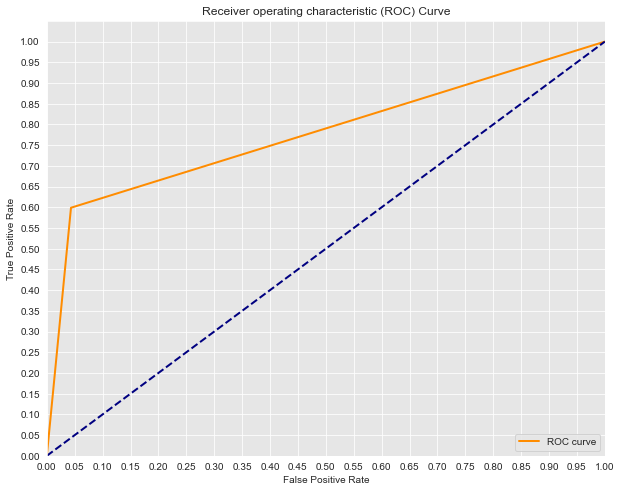

In [56]:
y_score = for2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [57]:
# Massive overfitting
print("Train score:",for2.score(X_train,y_train))
print("Test score: ",for2.score(X_test,y_test))

Train score: 0.9381003201707577
Test score:  0.5989304812834224


# Bagged Tree Modeling

In [58]:
bag_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('bag', BaggingClassifier())])

bag_grid1 = {'bag__base_estimator': [DecisionTreeClassifier()],
             'bag__n_estimators': [5,10,15,20],
             'bag__bootstrap': [True,False],
             'bag__bootstrap_features': [True,False]}

scoring_metrics = ['recall', 'f1']

bag_gs1 = GridSearchCV(estimator=bag_pipe1, param_grid=bag_grid1, scoring=scoring_metrics, refit='recall')

In [59]:
bag1 = bag_gs1.fit(X_train,y_train)

In [60]:
pd.DataFrame(bag1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.138273,0.009781,0.012266,0.000303,DecisionTreeClassifier(),True,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.632979,...,0.037458,7,0.634667,0.579545,0.593220,0.634667,0.598383,0.608096,0.022551,7
1,0.254587,0.014393,0.014044,0.000643,DecisionTreeClassifier(),True,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.457447,...,0.027178,16,0.554839,0.541667,0.530488,0.581602,0.589666,0.559652,0.022715,16
2,0.380876,0.021465,0.017574,0.000723,DecisionTreeClassifier(),True,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.590426,...,0.032053,6,0.623596,0.645161,0.588921,0.628099,0.656891,0.628534,0.023127,3
3,0.491237,0.017708,0.019511,0.000277,DecisionTreeClassifier(),True,True,20,{'bag__base_estimator': DecisionTreeClassifier...,0.542553,...,0.041173,14,0.607143,0.588235,0.615385,0.550633,0.577640,0.587807,0.022890,9
4,0.106048,0.007753,0.011406,0.000812,DecisionTreeClassifier(),True,False,5,{'bag__base_estimator': DecisionTreeClassifier...,0.611702,...,0.017423,2,0.602094,0.621410,0.624672,0.640420,0.622590,0.622237,0.012191,5
5,0.196659,0.010973,0.013211,0.000804,DecisionTreeClassifier(),True,False,10,{'bag__base_estimator': DecisionTreeClassifier...,0.611702,...,0.012325,4,0.659026,0.617564,0.612903,0.606557,0.632184,0.625647,0.018703,4
6,0.285236,0.014819,0.015263,0.000649,DecisionTreeClassifier(),True,False,15,{'bag__base_estimator': DecisionTreeClassifier...,0.643617,...,0.013693,1,0.640212,0.628571,0.636605,0.641096,0.664894,0.642275,0.012142,1
7,0.373624,0.017469,0.017637,0.000458,DecisionTreeClassifier(),True,False,20,{'bag__base_estimator': DecisionTreeClassifier...,0.611702,...,0.008190,3,0.642458,0.624000,0.636119,0.631579,0.642857,0.635403,0.007078,2
8,0.197086,0.021760,0.012066,0.000774,DecisionTreeClassifier(),False,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.537234,...,0.043638,12,0.577143,0.600536,0.632708,0.547550,0.575419,0.586671,0.028494,10
9,0.381158,0.025664,0.014707,0.000725,DecisionTreeClassifier(),False,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.611702,...,0.053389,15,0.638889,0.552941,0.561934,0.525000,0.570571,0.569867,0.037754,15


In [61]:
bag1.best_params_

{'bag__base_estimator': DecisionTreeClassifier(),
 'bag__bootstrap': True,
 'bag__bootstrap_features': False,
 'bag__n_estimators': 15}

AUC Score: 0.7919863286861729


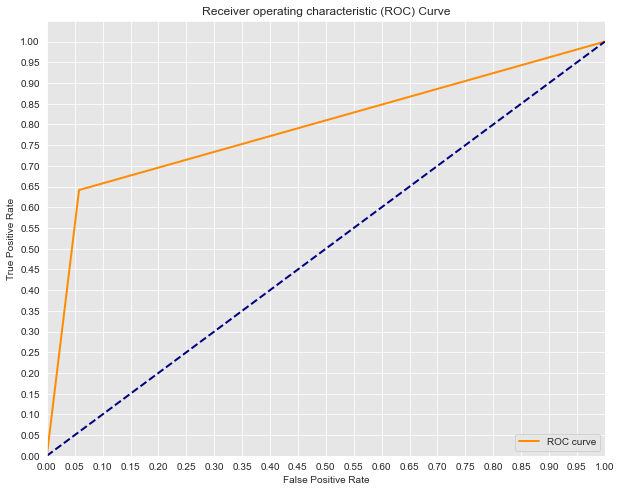

In [62]:
y_score = bag1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [63]:
# Massive overfitting
print("Train score:",bag1.score(X_train,y_train))
print("Test score: ",bag1.score(X_test,y_test))

Train score: 0.9967982924226254
Test score:  0.6417112299465241


In [64]:
bag_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('bag', BaggingClassifier())])

bag_grid2 = {'bag__base_estimator': [DecisionTreeClassifier()],
             'bag__n_estimators': [5,10,15,20],
             'bag__bootstrap': [True,False],
             'bag__bootstrap_features': [True,False],
             'bag__max_samples': [1,5,10],
             'bag__max_features': [1,5,10]}

scoring_metrics = ['recall', 'f1']

bag_gs2 = GridSearchCV(estimator=bag_pipe2, param_grid=bag_grid2, scoring=scoring_metrics, refit='recall')

In [65]:
bag2 = bag_gs2.fit(X_train,y_train)

In [66]:
pd.DataFrame(bag2.cv_results_).sort_values(by='rank_test_recall', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
48,0.025340,0.000747,0.009598,0.000725,DecisionTreeClassifier(),True,False,5,1,5,...,0.400000,1,0.000000,0.000000,0.000000,0.230864,0.000000,0.046173,0.092346,10
68,0.025493,0.000605,0.009757,0.001067,DecisionTreeClassifier(),True,False,10,10,5,...,0.159094,2,0.090452,0.000000,0.429319,0.376384,0.315412,0.242314,0.167372,1
32,0.025832,0.000707,0.008777,0.000286,DecisionTreeClassifier(),True,True,10,10,5,...,0.144665,3,0.081218,0.104762,0.051546,0.000000,0.252159,0.097937,0.084681,3
100,0.026432,0.001423,0.008787,0.000414,DecisionTreeClassifier(),False,True,10,5,5,...,0.141419,4,0.000000,0.000000,0.041885,0.490842,0.000000,0.106545,0.192832,2
21,0.032919,0.000974,0.009943,0.000195,DecisionTreeClassifier(),True,True,5,10,10,...,0.102674,5,0.000000,0.000000,0.367816,0.000000,0.000000,0.073563,0.147126,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.035786,0.001332,0.010684,0.000819,DecisionTreeClassifier(),True,True,10,1,10,...,0.000000,39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39
67,0.053790,0.001211,0.011774,0.000570,DecisionTreeClassifier(),True,False,10,5,20,...,0.000000,39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39
66,0.043433,0.000594,0.011147,0.000597,DecisionTreeClassifier(),True,False,10,5,15,...,0.000000,39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39
27,0.053039,0.000555,0.012141,0.000330,DecisionTreeClassifier(),True,True,10,1,20,...,0.000000,39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39


In [67]:
bag2.best_params_

{'bag__base_estimator': DecisionTreeClassifier(),
 'bag__bootstrap': True,
 'bag__bootstrap_features': False,
 'bag__max_features': 5,
 'bag__max_samples': 1,
 'bag__n_estimators': 5}

AUC Score: 0.5


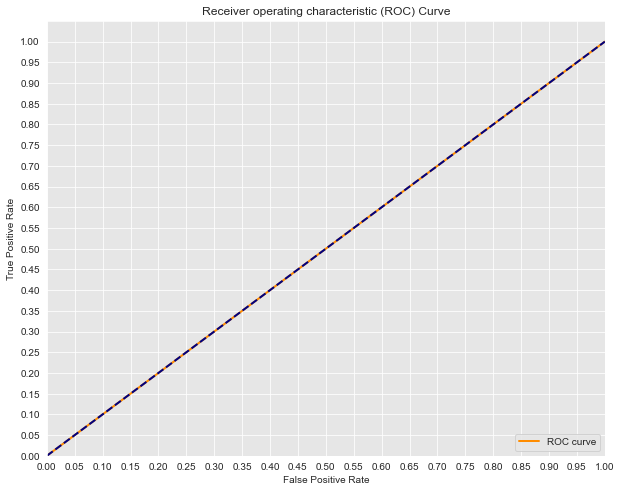

In [68]:
y_score = bag2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [69]:
# 0 doesn't seem good
print("Train score:",bag2.score(X_train,y_train))
print("Test score: ",bag2.score(X_test,y_test))

Train score: 0.0
Test score:  0.0
